<a href="https://colab.research.google.com/github/Nozasp/PredictiveCoding/blob/main/PC_VERY_Simple_PytorchOptimization_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import sys
import os, sys #os for global variable
from google.colab import drive

drive.mount('/content/gdrive')
path_to_module = "/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src/PC_param.ipynb" #path_to_module = '/content/gdrive/MyDrive/ColabNotebooks/PC_param.ipynb'

#os.symlink('/content/gdrive/MyDrive/Github/PredictiveCoding/main/src', path_to_module)
sys.path.append(path_to_module) # or sys.path.insert(0, path_to_module)
%cd /content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
!pwd

!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
PC_filters.ipynb    PC_Main.ipynb	     PC_param.ipynb		 PC_StimuliSequence.ipynb
PC_functions.ipynb  PC_Main_toPytorch.ipynb  PC_Step_8_loopJeiJii.ipynb


In [2]:
!pip install import_ipynb
#!pip install --target=$/content/gdrive/MyDrive/Github/PredictiveCoding/Lib/site-packages import_ipynb
!pip install lmfit

!pip install icecream

In [3]:
from lmfit import Model
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F #F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader # for batch and split Xtrain Ytrain dataset

import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
#from scipy.sparse import identity

from icecream import ic #for debugging. print variable name

# Functions

### Basics ones

In [4]:
# 2- Input/Output function
def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))#, param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
      plt.xlim(xlim_ar) #[0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()

def plot_s(range_sim, S_e, S_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei)) #, param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)
    if xlim_ar != None:
      plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    #plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()

# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()

In [5]:

# Filters gauss and Dog and LoG

def gaussian_filter(s, N):
    k = np.arange(1, N+1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
    gaussW2 = gaussW / (.009**2 / np.max(gaussW)) #1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N+1)
    gaussIn =  np.exp(-(k - k[:, np.newaxis])**2 / (2 * sIn**2))
    gaussOut = np.exp(-(k - k[:, np.newaxis])**2 / (2 * sOut**2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None :
        print('zero max')
        dog = 0
    else:
      dog = dog/ (.042**2 / np.max(dog)) #.0088
    return dog

def LoG_filter(s, N):
  x_lap = np.eye(N)
  lapl_filter = nd.gaussian_laplace(x_lap , sigma= (s, s))
  return lapl_filter


def dLogGaus(s =.61, N=20):
  dig = LoG_filter(s, N) + gaussian_filter(.019 *s, N)
  return dig

### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead

*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none

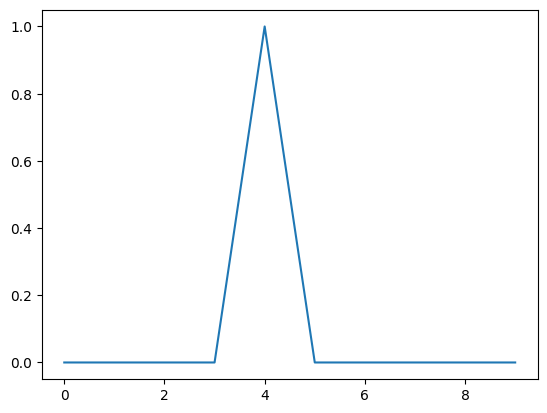

In [6]:
def relu_stim(x, stim):
  return torch.nn.functional.relu(1.0 - torch.abs(x - stim), inplace = False) #inplace = False to avoid implace operation

x = torch.cat((torch.tensor([10.,2.,2.,2.]),torch.tensor([8.]))).requires_grad_(True)
x = torch.cat((x,torch.zeros(5))).requires_grad_(True)
stim = torch.tensor([8,8,8,8,8,8,8,8,8,8], dtype = float).requires_grad_(True)

sisi = relu_stim(x, stim)
print(sisi.grad_fn)
plt.plot(torch.arange(10), sisi.detach().numpy())#, label = f"{round(x.item(),3)}")

Check if differentiable: # if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable else I get none

In [7]:
from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network
pars = default_parameters_network()

def Dirac(A, N= pars["NumN"]):
  y = scipy.signal.unit_impulse(N, idx= (torch.max(torch.argmax(A))))#, dtype= <class 'float'>)
  return torch.tensor(y)


#out = Dirac((x))
#print(out.grad_fn) # if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable else I get none


importing Jupyter notebook from /content/gdrive/MyDrive/Github/PredictiveCoding/main/Src/PC_param.ipynb
{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[-6.56214880e-04],
       [-7.20791630e-05],
       [ 7.16428183e-04],
       [-5.04560730e-04]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq

### Try "make it proba" to "make it proba"

In [8]:
def make_it_proba(r_e):
  #prob_r = torch.zeros((r_e.shape[0], r_e.shape[1])) #empty matrix initialisation
  sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0],1)
  #sum_r_e = sum_r_e.reshape(r_e.shape[0],1)
  prob_r = torch.div(r_e, sum_r_e)#torch.transpose(r_e, dim0=0 ,dim1=1) this pose problem
  print(prob_r.grad_fn)
  prob_r[prob_r != prob_r] = 0.05 #to replace nan to 1/20 - to sum to 1
  #print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

  return prob_r.reshape(r_e.shape[0],r_e.shape[1]) #log or not log?

def log_proba(proba_r):
  return torch.log(proba_r)


In [9]:
xmake = torch.tensor([[1.,2.],[3.,4.]],requires_grad =True)
god = torch.sum(make_it_proba(xmake))# .grad_fn
#make_it_proba(r_e).grad_fn
god.backward()

### Try softmax to "make it proba"

In [10]:
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)
"""
softMax_drdt = softmax(r_e) # Drdt here!
#Correct for the nan!
softMax_re = F.softmax(r_e, dim=1)
softMax_ri = F.softmax(r_i, dim=1)

print("softMax_drdt", softMax_drdt[1000,:])
#for i in range(5, 13):
 # plt.plot(torch.arange(3999), softMax_drdt[:,i], linewidth = .6)
"""

'\nsoftMax_drdt = softmax(r_e) # Drdt here!\n#Correct for the nan!\nsoftMax_re = F.softmax(r_e, dim=1)\nsoftMax_ri = F.softmax(r_i, dim=1)\n\nprint("softMax_drdt", softMax_drdt[1000,:])\n#for i in range(5, 13):\n # plt.plot(torch.arange(3999), softMax_drdt[:,i], linewidth = .6)\n'

In [11]:
x2 =torch.tensor([[0.,1.],[2.,3.]], requires_grad = True)
softmax(x2).grad_fn # check if differentiable

# Class

## 1- Basic classes

In [12]:
# ***************** CLASS ***************************************
from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network
pars = default_parameters_network()

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float  = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float  = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  #0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    # I1, I2 = pars['I1'], pars['I2']
    c_dash = pars['c_dash']
    sigma = pars['sigma']  #param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)

    sigmaIn = pars['sigmaIn']

    #Input parameters
    In0 = pars['In0']       #% Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']   #% Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']       #% Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']   #% Max firing rate of feedback populations (Hz)

    #Gaussian filter
    #sIn = pars['sigmaInh'][0]
    #sOut = pars['sigmaInh'][1]

    def __init__(self,sEI, sIn, sOut, N): # sEI=4, sIn=.2, sOut=1.2,
      # Weights (from gaussian filter)
      self.N = N  #pars['NumN']
      self.wei = torch.tensor(dog_filter(sOut, int(N)).astype(float))#, dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
      self.wii = torch.tensor(np.eye(int(N)).astype(float))#dog_filter(sIn, sOut, N)#np.eye(N) #
      self.wie = torch.tensor(gaussian_filter(sEI, int(N)).astype(float)) #dog_filter(sIn, sOut, N)
      self.wes = torch.tensor(np.eye(int(N)).astype(float)) # Identity matrix
      self.f = np.arange(1, N +1)
      self.sEI = sEI
      self.sIn = sIn
      self.sOut = sOut


    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())




# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size


    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°
class Neurons:
    def __init__(neur, Ltime, Ntime , RFfrequency =0, init_r=0, init_S=0 ):
        neur.r = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'), requires_grad = False)
        neur.drdt = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'), requires_grad = False)
        neur.S = torch.tensor(np.zeros((Ltime,Ntime), dtype='float64'), requires_grad = False)
        neur.Itot = (np.zeros((Ltime, Ntime), dtype='float64'))#, requires_grad = False
        neur.Phi = (np.zeros((Ltime, Ntime))) #np.zeros(Ltime)
        neur.rinit = init_r
        neur.Sinit = init_S
        neur.RFf = RFfrequency
        if neur.Sinit != 0:
          neur.S[0,:] = neur.Sinit
         # neur.S = np.full((Ltime, Ntime), neur.Sinit)



    def printNeur(neur):
        print("size S and r andItot and Phi is: ", neur.S.shape, neur.r.shape, neur.Itot.shape, neur.Phi.shape)



class Stim:
  def __init__(self, param, simu, f, ISI = 1, dur = 0.2): #8 #[10]
    self.f = f #array of frequency stimulus types
    self.ISI = ISI # inter-stimulus interval
    self.dur = dur #duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
    self.tail   = 0;
    self.predDt = 0;
    self.pred   = 0;
    self.InMax = param.InMax
    self.In0 = param.In0

    # Instantaneous frequency
    f_instant = np.zeros((int(self.ISI / simu.dt)+1, 1)) #size ISI : 1 /dt : 1000

    #print(f.shape)
    for fx in self.f:
      fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx, #just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                               np.zeros((int(self.ISI / simu.dt), 1))))   # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    f_stim = np.vstack((f_instant, fx_array)) #stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
    self.f_stim = f_stim[1:] #1400*1

  #bottom up sensory Input # duration 1sec
  def sensoryInput(self, parameter, simu,sigmaIn = None, paramf = None , f_stim = None, InMax = None, In0 = None):
      #paramf = np.arange(1, 101)
      w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

      #totalAct = w.sum(axis = 1) #sum over each row
      #norm_w = (w.T / totalAct).T # elementwise division
      In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0), 0) #if stim >0 give InMax * weight + In0 otherwise give 0
      if self.tail != 0:
        tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
        In = np.hstack((In, tail_zeros))

      range_sim = np.arange(1, In.shape[0] +1)
      self.In = In
      self.w = w
      self.sigmaIn = sigmaIn

      return In, range_sim, w, sigmaIn


  def printStim(self):
    print("frequence of stimulus f:", self.f, "  ISI:",self.ISI, " Size In:", self.In.shape, "Size w:", self.w.shape, "  f_stim:", self.f_stim.shape,
          "sigmaIn:", self.sigmaIn)



## 2- Model Classes

In [13]:
class MyModel(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel, self).__init__()
        torch.manual_seed(2020)
        # Define other model parameters, layers, or components here if needed
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)
        self.Jee = nn.Parameter((torch.tensor((self.dicJ['Jee']), requires_grad = True, dtype= float)))
        self.Jei = nn.Parameter((torch.tensor((self.dicJ['Jei']), requires_grad = True, dtype= float)))
        self.Jie = nn.Parameter((torch.tensor((self.dicJ['Jie']), requires_grad = True, dtype= float)))
        self.Jii = nn.Parameter((torch.tensor((self.dicJ['Jii']), requires_grad = True, dtype= float)))
        self.Jin = nn.Parameter((torch.tensor((self.dicJ['Jin']), requires_grad = True, dtype= float)))
        print(self.Jee, self.dicJ['Jee'])

    def phi(self, I_tot, a, b, hm):
        return torch.multiply(hm, torch.divide(1, (1 + torch.exp(- (torch.multiply(a, I_tot) + b)))))
        #return hm * (1 / (1 + torch.exp(- (a * I_tot + b))))

    def forward(self, stim):
        """
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        """
        In = stim
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0],self.N), dtype= float) #, requires_grad=True)
        r_i = torch.zeros((In.shape[0], self.N), dtype= float) #, requires_grad=True)
        s_ampa = torch.zeros((In.shape[0], self.N), dtype= float)
        s_gaba = torch.zeros((In.shape[0], self.N), dtype= float)
        i_tot_e = torch.zeros((In.shape[0], self.N), dtype= float)
        i_tot_i = torch.zeros((In.shape[0], self.N), dtype= float)
        dr_e_dt = torch.zeros((In.shape[0], self.N), dtype= float)
        dr_i_dt = torch.zeros((In.shape[0], self.N), dtype= float)


        # Perform integration over time steps
        for k in range(1, In.shape[0]):
            s_gaba_wie = s_gaba[k - 1, :] @ self.param.wie # replaced torch.matmul() by @
            s_ampa_wei = s_ampa[k - 1, :] @ self.param.wei #@ is an inplace operation!
            s_gaba_wii = s_gaba[k - 1, :] @ (self.param.wii)
            sampa = s_ampa.detach().clone()
            #Jee = self.Jee.clone()
            Sampa_Jee = self.Jee * sampa[k - 1, :] #self.Jee.clone() does not work
            IN_JIN = self.Jin * stim[k-1,:]
            #ic(Sampa_Jee.grad_fn)
            #ic(s_ampa.grad_fn)
            #ic(self.Jee.grad_fn)

            #print(Sampa_Jee.type)
            i_tot_e[k, :] =(Sampa_Jee) - (self.Jie * s_gaba_wie) + (IN_JIN)# stim=In #(torch.tensor(In[k-1,:], requires_grad = True).float()
            i_tot_i[k, :] = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

            phi_arr_e = self.phi(i_tot_e[k, :], self.param.ae, self.param.be, self.param.hme) #.detach().numpy()
            phi_arr_i = self.phi(i_tot_i[k, :], self.param.ai, self.param.bi, self.param.hmi) #.detach().numpy()

            dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
            dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        return r_e, r_i #, dr_e_dt, dr_i_dt # r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt

### Call the model and the classes

sIN 0.1 sout 3.0 sEI 0.2
Jee: 0.2   Jei: 1.4
Jii 6.7 Jie: 0.2  Jin: 0.008
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
Parameter containing:
tensor(0.0720, dtype=torch.float64, requires_grad=True) 0.072


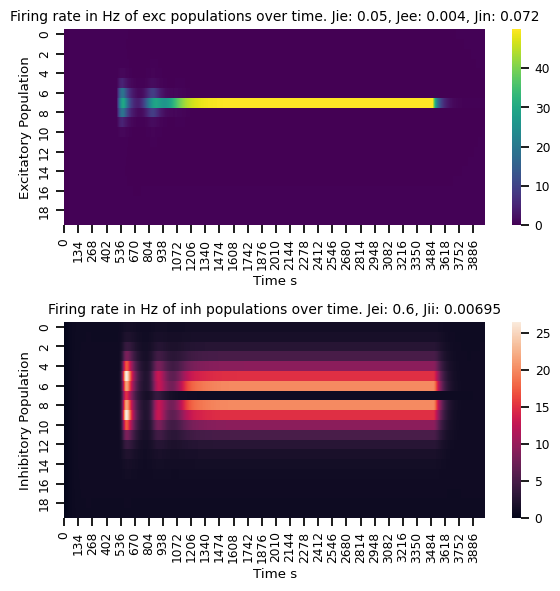

In [14]:
N=20
# \\\\\\\\\\\ Parameters
param = Parameter(N = 20, sIn = .1, sOut =3., sEI = .2)
sigmas = [param.sOut, param.sEI]# = sigmas
print("sIN", sigmas[0]/30, "sout", sigmas[0], "sEI", sigmas[1])
print("Jee:", param.Jee, "  Jei:", param.Jei)
print("Jii", param.Jii, "Jie:", param.Jie, " Jin:", param.Jin)
J = param.Jin, param.Jee, param.Jie, param.Jei, param.Jii

# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4) #dt #rangeSim #dur = 2s
simu.printSim()

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param,simu, dur=.3, f = [8],ISI=.05) #dur = 1s Isi=1s
In, range_sim, w, sigmaIn =stimuli.sensoryInput(param, simu, sigmaIn = 2.)
#stim.printStim()

# \\\\\\\\\\\ Neurons (empty variables)
pop3 = Neurons(In.shape[0], param.N)#
pop4 = Neurons(In.shape[0], param.N)


# Initialize the model

# +++++++++++++++++++++++++ Model ++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
mymodel = MyModel(param, simu, **J1)  #these ** pass J as an unpacked dict, not as a single positional argument
#mymodel.Jdic = J
#print(mymodel.dicJ['Jee'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In).float()
r_e, r_i = mymodel.forward(stim = sti)#  ,r_i, dr_e_dt, dr_i_dt, s_ampa, s_gaba, i_tot_e, i_tot_i, In,

HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)

In [15]:
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor): # input of the shape Xtrain_tensor[5,:,:]
  Xargmax = torch.argmax(X_train_tensor, dim = 1)
  #print(Xargmax.grad_fn)
  Xmax =torch.max(Xargmax)
  #print(Xmax.grad_fn)
  return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
  x_t = torch.transpose(X_train_tensor, 0,1)
  #print(x_t.grad_fn)
  dirac_2d = torch.zeros(x_t.shape)
  stim = get_stimuli_input(X_train_tensor) # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable
  #print(stim.grad_fn)
  for pop, t in enumerate(x_t):
    tpop = torch.tensor(pop)
    #print(tpop.grad_fn)
    dirac_2d[pop,:] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace = False).requires_grad_(True)
  dirac_2d = torch.transpose(dirac_2d, 1,0)
  #print(dirac_2d.grad_fn)
  return dirac_2d

def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
      dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0),torch.tensor(0.0))
    return dirac_1d

# Optimization

In [16]:
#Initialise  loss function, and the SGD optimizer
# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
optimizer = optim.SGD(mymodel.parameters(), lr=0.05) #, lr=0.05) or use optim.Adam(mymodel.parameters(), lr=.05)

# +++++++++++++++++++++++++ Loss ++++++++++++++++++++++++++++
#simpler_custom_loss(X_input_proba, Y_target)
#diff = torch.sum((X_input_proba - Y_target), axis =1).requires_grad_(True)

# +++++++++++++++++++++++++ Epochs +++++++++++++++++++++++++
num_epochs = 2 #5

In [17]:
torch.autograd.set_detect_anomaly(False)


In [21]:
#test customloss
J_list = list(J1.keys())
X_input = sti#.requires_grad_(True)

Y_target = get_expected_Y_relu(X_input)
#Y_target = get_expected_Y_relu_1d_where(X_input)

#Y_target.requires_grad_(True)
m = nn.Softmax(dim = 1)


losses = torch.zeros(num_epochs)
for epoch in range(num_epochs):
  optimizer.zero_grad()  # Zero the gradients
  #calculate output
  #mymodel.train()
  r_e, r_i = mymodel(X_input) #, r_I, dr_e_dt, dr_i_dt
  Y_prediction = softmax(r_e) #m(r_e) #make_it_proba(r_e)# #torch.exp(r_e) / torch.sum(torch.exp(r_e), axis=1))
  #ic(Y_prediction.grad_fn)
  #calculate loss
  loss = torch.sum(torch.sum((Y_prediction - Y_target), axis =1))
  #ic(loss.grad_fn)
  #print(f"\n loss for sample {epoch}", loss)
  #print(torch.isfinite(loss).all())
  #backprop
  #optimizer.zero_grad()
  loss.backward()#retain_graph=True
  optimizer.step()

  losses[epoch] = loss
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}, Loss_grad: {loss.grad_fn}')#.item()
  #optimizer.zero_grad()
  #print("x.grad", X_input.grad)
  for i, par in enumerate(mymodel.parameters()):
    print(J_list[i], par.grad)



Epoch [1/2], Loss: 1.801420000779528e-15, Loss_grad: <SumBackward0 object at 0x7c46975d6b90>
Jee tensor(-8.0978e-14, dtype=torch.float64)
Jei tensor(1.1846e-11, dtype=torch.float64)
Jie tensor(1.0296e-12, dtype=torch.float64)
Jii tensor(-2.1733e-14, dtype=torch.float64)
Jin tensor(-5.0611e-11, dtype=torch.float64)


RuntimeError: ignored

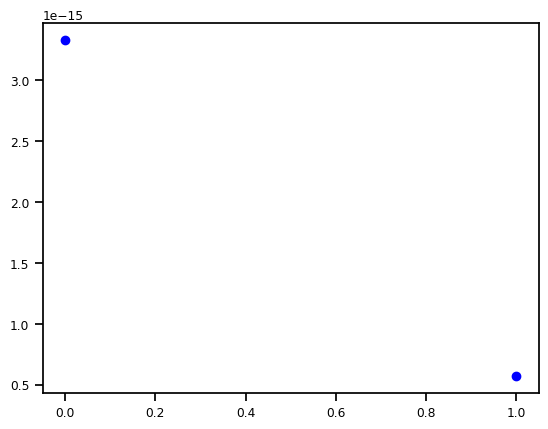

In [19]:
# Loss over time


plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')

In [20]:
import torch

# Create a sample computation graph
x = torch.tensor([2.0], requires_grad=True)
y = x * 3
z = y + 4
loss = z.mean()

# Start with the loss tensor
current_tensor = loss

print(f"Tensor: {current_tensor}")
print(f"Operation: {current_tensor.grad_fn}")

print(current_tensor.backward())

print(x.grad)
print(loss.grad)

Tensor: 10.0
Operation: <MeanBackward0 object at 0x7c4692e1be80>
None
tensor([3.])
None


<ipython-input-20-b8af2aafcc30>:18: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(loss.grad)
